In [1]:
import os
import json
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from recsys.models import WD
from recsys.data.movielens import MovielensDataset
from recsys.utils.metrics import evaluate
from recsys.utils import recommender, visualizer

In [2]:
with open("../configs/config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
with open(config["data"]["experiment_group"], "r") as f:
    experiment_group = json.load(f)
experiment_group[WD.model_name] = []
    
with open(config["data"]["num_sparse_features"], "r") as f:
    num_sparse_features = json.load(f)
    
with open(config["data"]["dense_features"], "r") as f:
    dense_features = json.load(f)

train = pd.read_parquet(config["data"]["train"])
test = pd.read_parquet(config["data"]["test"])

In [3]:
# Define Dataset
train_ds = MovielensDataset(train, list(num_sparse_features.keys()), dense_features)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config["training"]["batch_size"], shuffle=True)

test_ds = MovielensDataset(test, list(num_sparse_features.keys()), dense_features)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test["item_id"].nunique(), shuffle=False)

device = torch.device(config["training"]["device"])
model = WD(num_sparse_features=num_sparse_features, dense_features=dense_features, **config["models"][WD.model_name])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["training"]["lr"])
print(model)

WideAndDeep(
  (deep): Deep(
    (sparse_arch): ModuleDict(
      (user_id): Embedding(943, 16)
      (item_id): Embedding(1682, 16)
      (gender): Embedding(2, 16)
      (occupation): Embedding(21, 16)
      (genre): Embedding(19, 16)
    )
    (dense_arch): Linear(in_features=1, out_features=16, bias=False)
    (mlp): Sequential(
      (0): Linear(in_features=96, out_features=32, bias=False)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=False)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=False)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=1, bias=False)
    )
  )
  (wide): Wide(
    (sparse_arch): ModuleDict(
      (user_id): Embedding(943, 1)
      (item_id): Embedding(1682, 1)
      (gender): Embedding(2, 1)
      (occupation): Embedding(21, 1)
      (genre): Embedding(19, 1)
      (cross_gender_genre): Embedding(38, 1)
      (cross_gender_occupation): Embedding(42, 1)
    )
    (dense_arch): Linear(in_fe

Epoch 1/10: 100%|█| 5747/5747 [01:01<00:00, 92.86it/s, auc=0.0000, logloss=0.345
Epoch 2/10: 100%|█| 5747/5747 [00:55<00:00, 102.92it/s, auc=0.7249, logloss=0.32
Epoch 3/10: 100%|█| 5747/5747 [00:56<00:00, 102.49it/s, auc=0.8218, logloss=0.36
Epoch 4/10: 100%|█| 5747/5747 [00:54<00:00, 105.48it/s, auc=0.8294, logloss=0.38
Epoch 5/10: 100%|█| 5747/5747 [00:53<00:00, 106.90it/s, auc=0.8337, logloss=0.32
Epoch 6/10: 100%|█| 5747/5747 [00:54<00:00, 106.33it/s, auc=0.8380, logloss=0.16
Epoch 7/10: 100%|█| 5747/5747 [00:51<00:00, 111.23it/s, auc=0.8421, logloss=0.47
Epoch 8/10: 100%|█| 5747/5747 [00:54<00:00, 105.62it/s, auc=0.8466, logloss=0.44
Epoch 9/10: 100%|█| 5747/5747 [00:51<00:00, 111.49it/s, auc=0.8515, logloss=0.41
Epoch 10/10: 100%|█| 5747/5747 [00:46<00:00, 123.45it/s, auc=0.8571, logloss=0.2


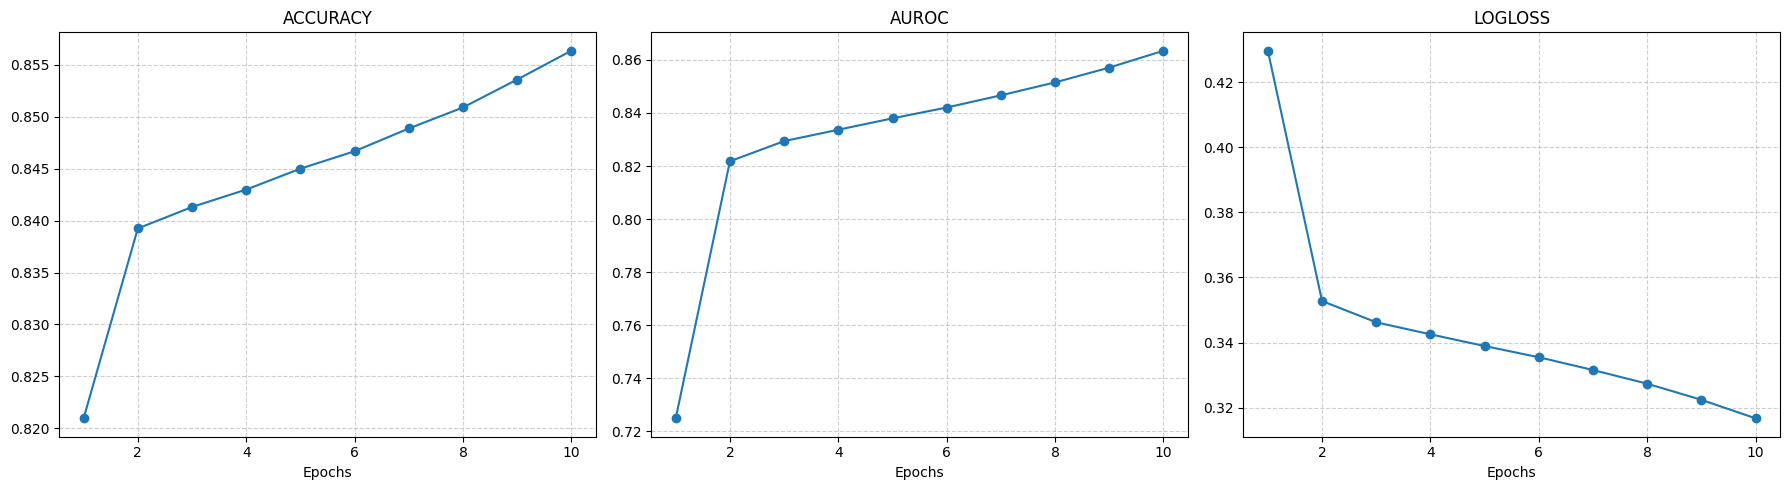

In [4]:
history = recommender.train(model, train_loader, optimizer, device, config["training"]["epochs"])
visualizer.plot_history(history)

Recommend (wd): 100%|████████████| 943/943 [00:12<00:00, 73.18it/s, user_id=942]


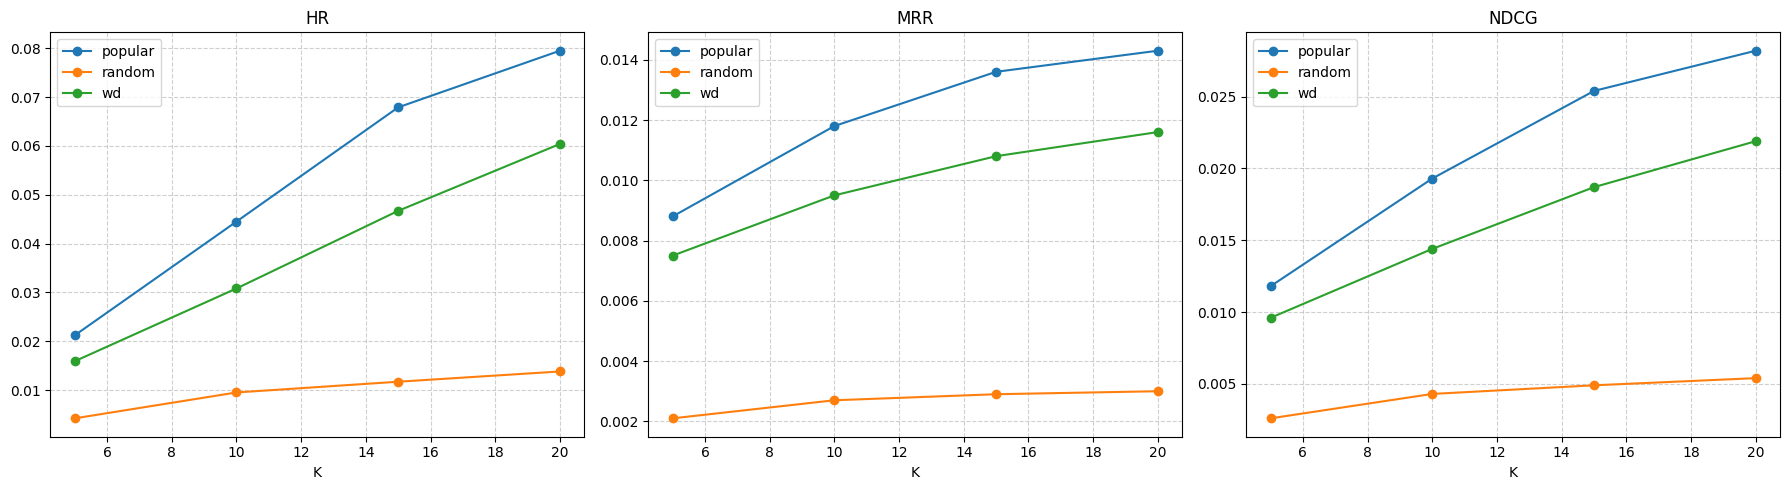

In [5]:
os.makedirs("results", exist_ok=True)
user_recommendations = recommender.inference(model, device, test_loader)
with open(f"results/{model.model_name}.json", "w") as f:
    json.dump({
        k: v.tolist() for k, v in user_recommendations.items()
    }, f)

ks = [5, 10, 15, 20]
_test = test[test["rating"]==1]
recommendations = {
    "popular": np.array(experiment_group["popular"]),
    "random": np.array(experiment_group["random"]),
    model.model_name: user_recommendations
}
results = evaluate(_test, recommendations, ks)
visualizer.plot_metrics(results)